# Completeness and Contamination

This Notebook is for the re-development and quantification of completeness and contamination of AGB stars

Jump to plots (<a href="#Create-Plots">here</a>)

In [2]:
## Importing my packages
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd

In [3]:
## The file names for my contaminant samples
cont_dir = "../contaminants/"
contam_files = [cont_dir+"lrg_allwise_allmags.dat", cont_dir+"vagc_allwise_allmags.dat",
                cont_dir+"pne_allwise_allmags.dat", cont_dir+"yso_allwise_allmags.dat",
                cont_dir+"dr12_sspp_allwise_allmags_w4snr_gt_3.dat"]

In [4]:
## The file names for my AGB samples
samp_dir = "../samples/"
sample_files = [samp_dir+"macho_allwise_allmags.dat", 
                samp_dir+"ogle3_allwise_allmags.dat", 
                samp_dir+"simbad_allwise_allmags.dat"]

In [21]:
## Reading the data into pandas dataframes
macho = pd.read_csv(sample_files[0], sep="\t")
ogle = pd.read_csv(sample_files[1], sep="\t")
simbad = pd.read_csv(sample_files[2], sep="\t")

lrg = pd.read_csv(contam_files[0], sep="\t")
vagc = pd.read_csv(contam_files[1], sep="\t")
vagc = vagc[vagc.CLASS != "STAR"]
yso = pd.read_csv(contam_files[2], sep="\t")
pne = pd.read_csv(contam_files[3], sep="\t")
sspp = pd.read_csv(contam_files[4], sep="\t")

## Data-manipulation functions

In [8]:
def clean_me(df):
    """
    Returns a dataframe for the sample where
    objects are within faint and saturation limits.
    We also cut on:
        Contamination & Confusion flags
        Number of 2MASS matches (limited to 1 and only 1)
        Signal to Noise ratios (> 3 for WISE bands)
        Extended source flags (<= 2)
        
    Adds columns for the following colors:
        coljh: J-H
        colhk: H-K
        coljk: J-K
        col12: W1-W2
        col23: W2-W3
        col34: W3-W4
        col13: W1-W3
    """
    fntlims = [16.83,15.6,11.32,8.0,16.5,16.0,15.5] ## W1-4, J, H, K
    brtlims = [2.0,1.5,-3.0,-4.0] ## W1-4
    
    df.glon[df.glon > 180] = df.glon[df.glon > 180] - 360
    
    if "w1" in df.columns:
        if "ccflag" in df.columns:
            cut = (df.w1 < fntlims[0]) & (df.w2 < fntlims[1]) & (df.w3 < fntlims[2]) & (df.w4 < fntlims[3]) & (df.w1 > brtlims[0]) & (df.w2 > brtlims[1]) & (df.w3 > brtlims[2]) & (df.w4 > brtlims[3]) & (df.ccflag == "0000") & (df.n2mass == 1) & (df.w1snr > 3) & (df.w2snr > 3) & (df.w3snr > 3) & (df.w4snr > 3) & (df.extflg <= 2)
        else:
            cut = (df.w1 < fntlims[0]) & (df.w2 < fntlims[1]) & (df.w3 < fntlims[2]) & (df.w4 < fntlims[3]) & (df.w1 > brtlims[0]) & (df.w2 > brtlims[1]) & (df.w3 > brtlims[2]) & (df.w4 > brtlims[3]) & (df.n2mass == 1) & (df.w1snr > 3) & (df.w2snr > 3) & (df.w3snr > 3) & (df.w4snr > 3) & (df.extflg <= 2)

        df["coljh"] = df.jmag - df.hmag
        df["colhk"] = df.hmag - df.kmag
        df["coljk"] = df.jmag - df.kmag
        df["col12"] = df.w1 - df.w2
        df["col23"] = df.w2 - df.w3
        df["col34"] = df.w3 - df.w4
        df["col13"] = df.w1 - df.w3
            
    else:
        if "ccflag" in df.columns:
            cut = (df.w1mpro < fntlims[0]) & (df.w2mpro < fntlims[1]) & (df.w3mpro < fntlims[2]) & (df.w4mpro < fntlims[3]) & (df.w1mpro > brtlims[0]) & (df.w2mpro > brtlims[1]) & (df.w3mpro > brtlims[2]) & (df.w4mpro > brtlims[3]) & (df.ccflag == "0000") & (df.n_2mass == 1) & (df.w1snr > 3) & (df.w2snr > 3) & (df.w3snr > 3) & (df.w4snr > 3) & (df.ext_flg <= 2)
        else:
            cut = (df.w1mpro < fntlims[0]) & (df.w2mpro < fntlims[1]) & (df.w3mpro < fntlims[2]) & (df.w4mpro < fntlims[3]) & (df.w1mpro > brtlims[0]) & (df.w2mpro > brtlims[1]) & (df.w3mpro > brtlims[2]) & (df.w4mpro > brtlims[3]) & (df.n_2mass == 1) & (df.w1snr > 3) & (df.w2snr > 3) & (df.w3snr > 3) & (df.w4snr > 3) & (df.ext_flg <= 2)


        df["coljh"] = df.j_m_2mass - df.h_m_2mass
        df["colhk"] = df.h_m_2mass - df.k_m_2mass
        df["coljk"] = df.j_m_2mass - df.k_m_2mass
        df["col12"] = df.w1mpro - df.w2mpro
        df["col23"] = df.w2mpro - df.w3mpro
        df["col34"] = df.w3mpro - df.w4mpro
        df["col13"] = df.w1mpro - df.w3mpro

    return df[cut]

In [9]:
def cut_me(df):
    """
    Returns a dataframe with objects subjected
    to WISE-2MASS cuts, created specifically 
    for AGB stars in WISE color-color space
    """
    if "w1" in df.columns:
        col1 = df.jmag - df.kmag
        col2 = df.w2 - df.w3
        col3 = df.w3 - df.w4
        
    else:
        col1 = df.j_m_2mass - df.k_m_2mass
        col2 = df.w2mpro - df.w3mpro
        col3 = df.w3mpro - df.w4mpro
            
    cut = (col1 > 1.1) & (col2 > 0.3) & (col3 < -0.83*col2 + 3.37)
    
    return df[cut]


In [10]:
def combine_dfs(dfs):
    """
    This function is for combining data frames 
    into one, with common columns so that we 
    don't have null values and whatnot, AND
    with unique sources.
    The standard is...
    
    wisename
    ra, decl, glon, glat
    jmag, hmag, kmag
    jerr, herr, kerr
    w1, w2, w3, w4
    w1err, w2err, w3err, w4err
    ccflag, match_rad, n2mass, r2mass
    extflg, var_flg
    """
    ## Loop through dataframes and rename columns
    for ii in range(len(dfs)):
        rename_these = {}
        if "designation" in dfs[ii].columns:
            rename_these["designation"] = "wisename"
        if "cc_flags" in dfs[ii].columns:
            rename_these["cc_flags"] = "ccflag"
        if "ext_flg" in dfs[ii].columns:
            rename_these["ext_flg"] = "extflg"
        if "j_m_2mass" in dfs[ii].columns:
            rename_these["j_m_2mass"] = "jmag"
        if "h_m_2mass" in dfs[ii].columns:
            rename_these["h_m_2mass"] = "hmag"
        if "k_m_2mass" in dfs[ii].columns:
            rename_these["k_m_2mass"] = "kmag"
        if "j_msig_2mass" in dfs[ii].columns:
            rename_these["j_msig_2mass"] = "jerr"
        if "h_msig_2mass" in dfs[ii].columns:
            rename_these["h_msig_2mass"] = "herr"
        if "k_msig_2mass" in dfs[ii].columns:
            rename_these["k_msig_2mass"] = "kerr"
        if "n_2mass" in dfs[ii].columns:
            rename_these["n_2mass"] = "n2mass"
        if "r_2mass" in dfs[ii].columns:
            rename_these["r_2mass"] = "r2mass"
        if "w1mpro" in dfs[ii].columns:
            rename_these["w1mpro"] = "w1"
        if "w2mpro" in dfs[ii].columns:
            rename_these["w2mpro"] = "w2"
        if "w3mpro" in dfs[ii].columns:
            rename_these["w3mpro"] = "w3"
        if "w4mpro" in dfs[ii].columns:
            rename_these["w4mpro"] = "w4"
        if "w1sigmpro" in dfs[ii].columns:
            rename_these["w1sigmpro"] = "w1err"
        if "w2sigmpro" in dfs[ii].columns:
            rename_these["w2sigmpro"] = "w2err"
        if "w3sigmpro" in dfs[ii].columns:
            rename_these["w3sigmpro"] = "w3err"
        if "w4sigmpro" in dfs[ii].columns:
            rename_these["w4sigmpro"] = "w4err"
        if "matchrad_as" in dfs[ii].columns:
            rename_these["matchrad_as"] = "match_rad"
        if "dist_x" in dfs[ii].columns:
            rename_these["dist_x"] = "match_rad"
        if "dec" in dfs[ii].columns:
            rename_these["dec"] = "decl"
        if "wdecl" in dfs[ii].columns:
            rename_these["wdecl"] = "decl"
        if "wra" in dfs[ii].columns:
            rename_these["wra"] = "ra"
            
        dfs[ii].rename(columns=rename_these, inplace=True)
    
    unique_dfs = pd.concat(dfs)

    ## Create a list of unique wise designations from df[0]
    ## Create a corresponding boolean array of all Trues
    ## Check the wise designations in the next df 
    ## Add new designations to the list
    ## Add appropriate boolean to new list of booleans
    ## 
    ## Concatenate dataframes with booleans
    names = []
    unique_dfs = []
    for ii in range(len(dfs)):
        bools = []
        for jj in range(len(dfs[ii])):
            if dfs[ii].iloc[jj].wisename not in names:
                names.append(dfs[ii].iloc[jj].wisename)
                bools.append(True)
            else:
                bools.append(False)
        
        bools = np.array(bools)
        unique_dfs.append(dfs[ii][bools])
        
    unique_dfs = pd.concat(unique_dfs)
    return unique_dfs

In [ ]:
vagc = clean_me(vagc)
lrg = clean_me(lrg)
sspp = clean_me(sspp)

test = combine_dfs([vagc, lrg, sspp])

print len(test)
print len(vagc) + len(lrg) + len(sspp)

## Plotting Functions

In [24]:
def galactic_pos(df, histo=True):
    
    fig = plt.figure(figsize=(6,4))
    ax = plt.subplot(111)
    if histo==True:
        dx = 1.
        dy = 1.

        xbins = np.arange(-180., 180.+dx, dx)
        ybins = np.arange(-90., 90.+dy, dy)
        Htot, xedges, yedges = np.histogram2d(df.glon, df.glat, bins=(xbins, ybins))
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        imap = ax.imshow(np.log10(Htot.T), extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.cubehelix, origin="lower")
    
    else:
        ax.scatter(df.glon, df.glat, s=1, c='k', edgecolor='None')
    ax.set_xlim(-179,179)
    ax.set_ylim(-89,89)
    ax.set_xlabel("glon")
    ax.set_ylabel("glat")
    ax.minorticks_on()
    
    plt.show()

In [25]:
def color_color(df, xmag1, xmag2, ymag1, ymag2, scatter=False, plttext=None):
    xcolor = df[xmag1] - df[xmag2]
    ycolor = df[ymag1] - df[ymag2]
    
    dx = dy = 0.05
    
    xbins = np.arange(-0.5, 4.+dx, dx)
    ybins = np.arange(-0.5, 4.+dy, dy)
    H, xedges, yedges = np.histogram2d(xcolor, ycolor, bins=(xbins,ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    fig = plt.figure(figsize=(7,5))
    ax = plt.subplot(111)

    if scatter == True:
        ax.scatter(xcolor, ycolor, s=1, edgecolor="None", c='k')
    else:
        imap = ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.cubehelix, origin="lower")
    
        cbar = fig.colorbar(imap)
        cbar.set_label("N Objects")
        
    if type(plttext) != type(None):
        ax.text(0.9,0.9,plttext,horizontalalignment="right",transform=ax.transAxes)
    
    ax.set_xlim(-0.5, 4)
    ax.set_xlabel(xmag1+" - "+xmag2)
    ax.set_ylim(-0.5, 4)
    ax.set_ylabel(ymag1+" - "+ymag2)
    ax.minorticks_on()
    plt.show()

In [26]:
def color_mag(df, xmag1, xmag2, ymag, scatter=False, plttext=None):
    xcolor = df[xmag1] - df[xmag2]
    y = df[ymag]
    
    dx = 0.05
    dy = 0.1
    
    xbins = np.arange(-0.5, 4.+dx, dx)
    ybins = np.arange(-4, 18.+dy, dy)
    H, xedges, yedges = np.histogram2d(xcolor, y, bins=(xbins,ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    fig = plt.figure(figsize=(7,5))
    ax = plt.subplot(111)

    if scatter == True:
        ax.scatter(xcolor, y, s=1, edgecolor="None", c='k')
    else:
        imap = ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.cubehelix, origin="lower")
    
        cbar = fig.colorbar(imap)
        cbar.set_label("N Objects")
        
    if type(plttext) != type(None):
        ax.text(0.9,0.9,plttext,horizontalalignment="right",transform=ax.transAxes)
    
    ax.set_xlim(-0.5, 4)
    ax.set_xlabel(xmag1+" - "+xmag2)
    ax.set_ylim(max(y),-0.5)
    ax.set_ylabel(ymag)
    ax.minorticks_on()
    plt.show()

In [27]:
def completeness_galmap_colmap(df, cuts=None, vmin=-2, cmap=plt.cm.cubehelix_r):    
    dx = 1.
    dy = 1.
    
    xbins = np.arange(-180., 180.+dx, dx)
    ybins = np.arange(-90., 90.+dy, dy)
    Htot, xedges, yedges = np.histogram2d(df.glon, df.glat, bins=(xbins, ybins))
    extent_tot = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(wspace=0.3)
    ax = plt.subplot2grid((2,2),(0,0),colspan=2)

    if type(cuts) != type(None):
        df_cut = df[cuts]
        Hcut, xedges, yedges = np.histogram2d(df_cut.glon, df_cut.glat, bins=(xbins, ybins))
        imap = ax.imshow(np.log10((Hcut/Htot).T), extent=extent_tot, aspect="auto", interpolation="bicubic", cmap=cmap, origin="lower", vmin=vmin, vmax=0)
        
        completeness_string = "Completeness: %.2f%%" % (len(df_cut)/float(len(df)) * 100)
        ax.text(0.9,0.9, completeness_string, transform=ax.transAxes, horizontalalignment="right")
        
    else:
        imap = ax.imshow(np.log10(Htot.T/float(len(df))), extent=extent_tot, aspect="auto", interpolation="nearest", cmap=cmap, origin="lower", vmin=vmin, vmax=0)
        
    ax.set_xlim(-179, 179)
    ax.set_xlabel("gal $l$ (deg)")
    ax.set_ylim(-89, 119)
    ax.set_ylabel("gal $b$ (deg)")
    ax.minorticks_on()
    
    ax = plt.subplot2grid((2,2),(1,0))
    if type(cuts) != type(None):
        xcolor1 = df.w2 - df.w3
        xcolor2 = df_cut.w2 - df_cut.w3
        ycolor1 = df.jmag - df.kmag
        ycolor2 = df_cut.jmag - df_cut.kmag

        dx = dy = 0.1

        xbins = np.arange(-4, 4.+dx, dx)
        ybins = np.arange(-4, 4.+dy, dy)
        
        Htot, xedges, yedges = np.histogram2d(xcolor1, ycolor1, bins=(xbins,ybins))
        Hcut, xedges, yedges = np.histogram2d(xcolor2, ycolor2, bins=(xbins,ybins))
        
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        ax.imshow(np.log10((Hcut/Htot).T), extent=extent, aspect="auto", interpolation="nearest", cmap=cmap, origin="lower", vmin=vmin, vmax=0)

    else:
        ax.scatter(df.col23, df.coljk, s=1, c='k', edgecolor="None")
    
    ax.plot([-1,4],[1.1,1.1],linestyle="--",color='k')
    ax.plot([0.3,0.3],[-1,4],linestyle="--",color='k')
    ax.set_xlim(-0.5, 4)
    ax.set_xlabel("W2 - W3")
    ax.set_ylim(-0.5, 4)
    ax.set_ylabel("J - K$_s$")
    ax.minorticks_on()
    
    ax = plt.subplot2grid((2,2),(1,1))
    if type(cuts) != type(None):
        xcolor1 = df.w2 - df.w3
        xcolor2 = df_cut.w2 - df_cut.w3
        ycolor1 = df.w3 - df.w4
        ycolor2 = df_cut.w3 - df_cut.w4

        dx = dy = 0.1

        xbins = np.arange(-4, 4.+dx, dx)
        ybins = np.arange(-4, 4.+dy, dy)
        
        Htot, xedges, yedges = np.histogram2d(xcolor1, ycolor1, bins=(xbins,ybins))
        Hcut, xedges, yedges = np.histogram2d(xcolor2, ycolor2, bins=(xbins,ybins))
        
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        ax.imshow(np.log10((Hcut/Htot).T), extent=extent, aspect="auto", interpolation="nearest", cmap=cmap, origin="lower", vmin=vmin, vmax=0)

    else:
        ax.scatter(df.col23, df.col34, s=1, c='k', edgecolor="None")
        
    ax.plot([0.3,0.3],[-1,4],linestyle="--",color='k')
    ax.plot([-1,4],[4.2,0.05],linestyle="--",color='k')
    ax.set_xlim(-0.5, 4)
    ax.set_xlabel("W2 - W3")
    ax.set_ylim(-0.5, 4)
    ax.set_ylabel("W3 - W4")
    ax.minorticks_on()

    cax = fig.add_axes([0.925, 0.125, 0.03, 0.775]) 
    cbar = plt.colorbar(imap, cax = cax, ticks=np.arange(-1.3, 0.1, 0.1))
    
    cbar.ax.set_ylabel("log$_{10}$(Frac Objects)", fontsize=16)

    plt.show()

In [47]:
def contamination_galmap_colmap(df, conts, cuts="None", vmax=1.0):
    dx = 1.
    dy = 1.
    
    xbins = np.arange(-180., 180.+dx, dx)
    ybins = np.arange(-90., 90.+dy, dy)
    Hsample, xedges, yedges = np.histogram2d(df.glon, df.glat, bins=(xbins, ybins))
    
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(wspace=0.3)
    ax = plt.subplot2grid((2,2),(0,0),colspan=2)

    if type(cuts) != type(None):
        conts_cut = conts[cuts]
        Hcont, xedges, yedges = np.histogram2d(conts_cut.glon, conts_cut.glat, bins=(xbins, ybins))
        imap = ax.imshow((Hcont/(Hsample + Hcont)).T, extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.gnuplot, origin="lower", vmax=vmax)
        
        contam_string = "Total Contamination: %.2f%%" % (len(conts_cut)/float(len(df) + len(conts_cut)) * 100)
        ax.text(0.9,0.9, contam_string, transform=ax.transAxes, horizontalalignment="right")
                
    ax.set_xlim(-179, 179)
    ax.set_xlabel("gal $l$ (deg)")
    ax.set_ylim(-89, 119)
    ax.set_ylabel("gal $b$ (deg)")
    ax.minorticks_on()

    ax = plt.subplot2grid((2,2),(1,0))
    if type(cuts) != type(None):
        xcolor1 = df.col23
        xcolor2 = conts_cut.col23
        ycolor1 = df.coljk
        ycolor2 = conts_cut.coljk

        dx = dy = 0.1

        xbins = np.arange(-0.5, 4.+dx, dx)
        ybins = np.arange(-0.5, 4.+dy, dy)
        
        Hsample, xedges, yedges = np.histogram2d(xcolor1, ycolor1, bins=(xbins,ybins))
        Hcont, xedges, yedges = np.histogram2d(xcolor2, ycolor2, bins=(xbins,ybins))
        
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        ax.imshow((Hcont/(Hsample+Hcont)).T, extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.gnuplot, origin="lower", vmax=vmax)
    
    ax.plot([-1,4],[1.1,1.1],linestyle="--",color='k')
    ax.plot([0.3,0.3],[-1,4],linestyle="--",color='k')
    ax.set_xlim(-0.5, 4)
    ax.set_xlabel("W2 - W3")
    ax.set_ylim(-0.5, 4)
    ax.set_ylabel("J - K$_s$")
    ax.minorticks_on()
    
    ax = plt.subplot2grid((2,2),(1,1))
    if type(cuts) != type(None):
        xcolor1 = df.col23
        xcolor2 = conts_cut.col23
        ycolor1 = df.col34
        ycolor2 = conts_cut.col34

        dx = dy = 0.1

        xbins = np.arange(-0.5, 4.+dx, dx)
        ybins = np.arange(-0.5, 4.+dy, dy)
        
        Hsample, xedges, yedges = np.histogram2d(xcolor1, ycolor1, bins=(xbins,ybins))
        Hcont, xedges, yedges = np.histogram2d(xcolor2, ycolor2, bins=(xbins,ybins))
        
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        ax.imshow((Hcont/(Hcont+Hsample)).T, extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.gnuplot, origin="lower", vmax=vmax)

        
    ax.plot([0.3,0.3],[-1,4],linestyle="--",color='k')
    ax.plot([-1,4],[4.2,0.05],linestyle="--",color='k')
    ax.set_xlim(-0.5, 4)
    ax.set_xlabel("W2 - W3")
    ax.set_ylim(-0.5, 4)
    ax.set_ylabel("W3 - W4")
    ax.minorticks_on()    

    cax = fig.add_axes([0.925, 0.125, 0.03, 0.775]) 
    cbar = plt.colorbar(imap, cax = cax)  
    cbar.ax.set_ylabel("Frac Objects")

    plt.show()

In [73]:
def color_mag_compare(df1, df2, xmag1, xmag2, ymag, scatter=False, plttext1=None, plttext2=None, ymax=None, vmax=None):
    xcolor1 = df1[xmag1] - df1[xmag2]
    xcolor2 = df2[xmag1] - df2[xmag2]
    y1 = df1[ymag]
    y2 = df2[ymag]
    
    dx = 0.05
    dy = 0.1
    
    xbins = np.arange(-0.5, 4.+dx, dx)
    ybins = np.arange(-4, 18.+dy, dy)
    
    H1, xedges, yedges = np.histogram2d(xcolor1, y1, bins=(xbins,ybins))
    H2, xedges, yedges = np.histogram2d(xcolor2, y2, bins=(xbins,ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    fig = plt.figure(figsize=(12,5))
    ax = plt.subplot(121)

    if scatter == True:
        ax.scatter(xcolor1, y1, s=1, edgecolor="None", c='k')
    else:
        if vmax:
            imap = ax.imshow(np.log10(H1.T), extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.gnuplot, origin="lower", vmax=vmax)
        else:
            imap = ax.imshow(np.log10(H1.T), extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.gnuplot, origin="lower", vmax=1.5)

    if plttext1:
        ax.text(0.9,0.9,plttext1,horizontalalignment="right",transform=ax.transAxes)

    ax.set_xlim(-0.5, 4)
    ax.set_xlabel(xmag1+" - "+xmag2)
    if ymax:
        ax.set_ylim(ymax, -0.5)
    else:
        ax.set_ylim(max(y1),-0.5)
    ax.set_ylabel(ymag)
    ax.minorticks_on()
    
    ax = plt.subplot(122)

    if scatter == True:
        ax.scatter(xcolor2, y2, s=1, edgecolor="None", c='k')
    else:
        if vmax:
            imap = ax.imshow(np.log10(H2.T), extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.gnuplot, origin="lower", vmax=vmax)
        else:
            imap = ax.imshow(np.log10(H2.T), extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.gnuplot, origin="lower", vmax=1.5)
            
    if plttext2:
        ax.text(0.9,0.9,plttext2,horizontalalignment="right",transform=ax.transAxes)

    ax.set_xlim(-0.5, 4)
    ax.set_xlabel(xmag1+" - "+xmag2)
    if ymax:
        ax.set_ylim(ymax, -0.5)
    else:
        ax.set_ylim(max(y1),-0.5)
    ax.set_ylabel(ymag)
    ax.minorticks_on()

    if scatter == False:
        cax = fig.add_axes([0.925, 0.125, 0.03, 0.775]) 
        cbar = plt.colorbar(imap, cax = cax)
        cbar.set_label("log$_{10}(N_{obj})$")

    plt.show()

In [94]:
def class_histo(df, dfname):
    numbers = []

#     if "SUBCLASS" in df.columns:
#         cut_df = cut_me(df)
#         classes = list(set(df.SUBCLASS))        
#         for ii in range(len(classes)):
#             numbers.append(sum(df.SUBCLASS == classes[ii]))
            
#     else:
#         cut_df = cut_me(df)
#         classes = list(set(df.SPECTYPE_SUBCLASS))        
#         for ii in range(len(classes)):
#             numbers.append(sum(df.SPECTYPE_SUBCLASS == classes[ii]))
    cut_df = cut_me(df)
    classes = list(set(df.SPECTYPE_SUBCLASS))        
    for ii in range(len(classes)):
        numbers.append(sum(df.SPECTYPE_SUBCLASS == classes[ii]))
 
    plt.figure(figsize=(8,4))
    ax = plt.subplot(111)
    ax.bar(range(len(classes)), numbers)
    for ii in range(len(classes)):
        ax.text(ii+0.15, numbers[ii]+1, classes[ii])

    ax.set_xlim(0,15)
    ax.set_ylim(0,10)
    ax.set_ylabel("N Objects")
    ax.set_xticks(range(1, len(classes)+1))
    ax.minorticks_on()
#     plt.savefig("../figures/contaminating_"+dfname+"_objects_classes.pdf")
    plt.show()

## Clean and Combine Data

In [77]:
ogle = clean_me(ogle)
simbad = clean_me(simbad)
macho = clean_me(macho)
agbs = combine_dfs((ogle,macho,simbad))

sspp = clean_me(sspp)
vagc = clean_me(vagc)
lrg = clean_me(lrg)
contams = combine_dfs((sspp,vagc,lrg))

## Create Plots

### The WISE Color-Color distribution of AGB stars
What is the color-color distribution of AGB stars before color-color criteria are applied (but after quality criteria)?

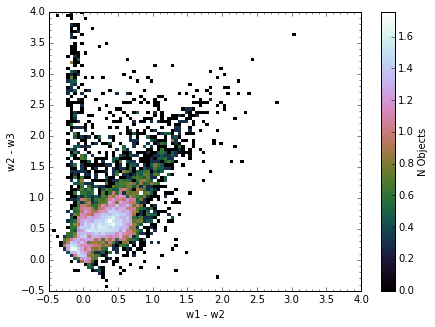

In [46]:
color_color(agbs, "w1", "w2", "w2", "w3")

### Sample Completeness
We can define overall sample completeness by looking at the number of objects retained after color-color criteria are applied. We can also look at positional completeness, and completeness in color color space.

The top panel shows positional completeness, with bins of 1$^\circ$ on each axis. The sources are dominated by objects obtained by SIMBAD so they mostly trace out that footprint, but completeness dips in regions of high stellar number density and dust extinction.

The bottom two panels show the color-color criteria we're using to reduce our sample. We want to know not just what the overall completeness is, but how that completeness varies in color-color space. Binning is in 0.1 dex on each axis.

The color scale shows completeness as a fraction of 1.0 (where 1.0 is full representation) in log space. So "-0.4" is a completeness of 10$^{-0.4}$ which is 0.398, or 39.8%

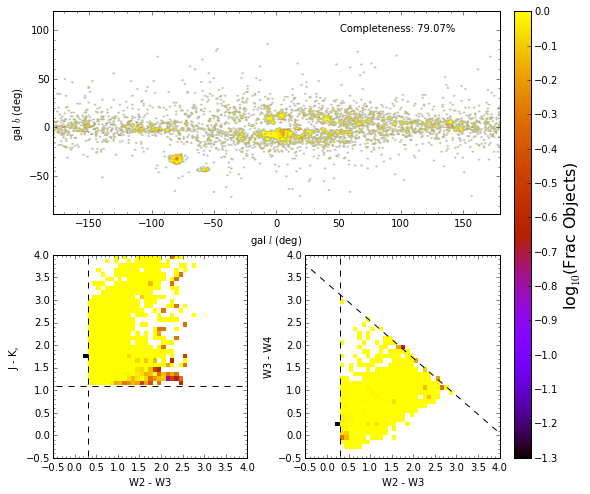

In [99]:
completeness_galmap_colmap(agbs, cuts=(agbs.jmag - agbs.kmag > 1.1) & (agbs.w2 - agbs.w3 > 0.3) & ((agbs.w3 - agbs.w4) < -0.83*(agbs.w2 - agbs.w3) + 3.37), vmin=-1.3, cmap=plt.cm.gnuplot)

### Contamination from Galactic and Extragalactic Sources
We define contamination as

$\eta = \frac{N_{cont}}{N_{cont} + N_{samp}}$

where $N_{cont}$ is the number of contaminant objects and $N_{samp}$ is the number of sample objects. With the same binning and color criteria as above, we see how contaminated our sample is with position and color.

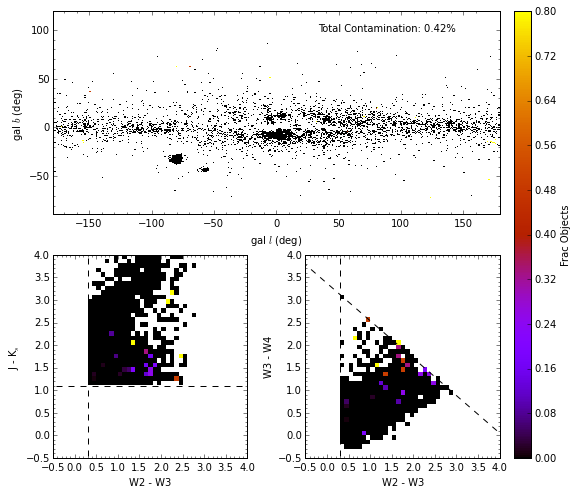

In [48]:
contamination_galmap_colmap(cut_me(agbs), contams, cuts=(contams.coljk > 1.1) & (contams.col23 > 0.3) & (contams.col34 < -0.83*contams.col23 + 3.37), vmax=0.8)

# Color-Magnitude Plots
We plot color-magnitude diagrams of our samples and contaminants after color-color criteria are applied. The goal here is to see where the data bunches, and how badly we're losing objects at the faint ends.

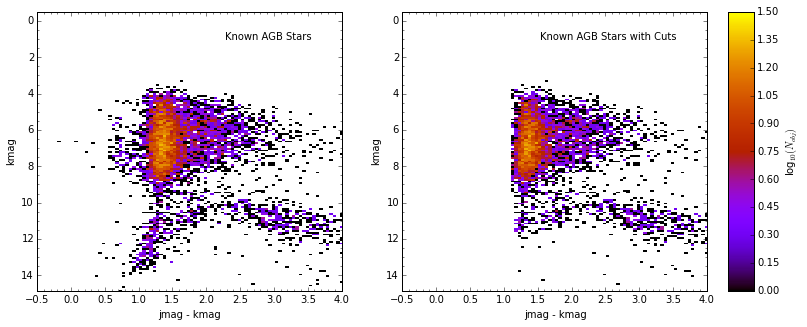

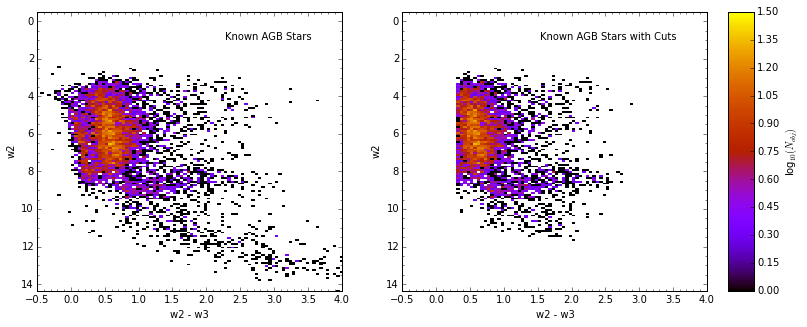

In [67]:
color_mag_compare(agbs, cut_me(agbs),"jmag","kmag","kmag",plttext1="Known AGB Stars", plttext2="Known AGB Stars with Cuts")
color_mag_compare(agbs, cut_me(agbs),"w2","w3","w2",plttext1="Known AGB Stars", plttext2="Known AGB Stars with Cuts")

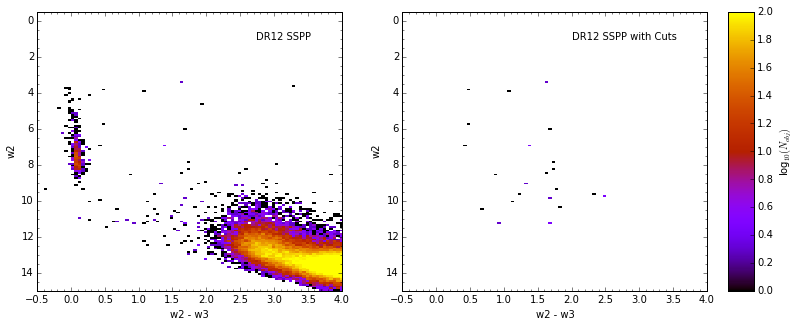

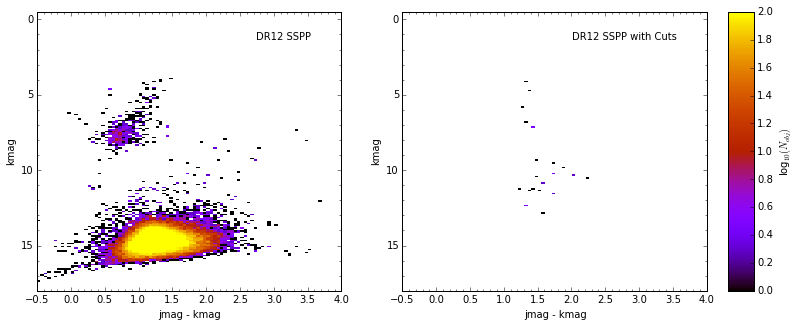

In [80]:
color_mag_compare(sspp, cut_me(sspp),"w2","w3","w2",plttext1="DR12 SSPP", plttext2="DR12 SSPP with Cuts", ymax=15, vmax=2)
color_mag_compare(sspp, cut_me(sspp),"jmag","kmag","kmag",plttext1="DR12 SSPP", plttext2="DR12 SSPP with Cuts", ymax=18, vmax=2)

In [91]:
cut_sspp = cut_me(sspp)
cut_vagc = cut_me(vagc)
vagc_classes = list(set(vagc.SUBCLASS))
classes = list(set(cut_sspp.SPECTYPE_SUBCLASS))

In [92]:
numbers = []
for ii in range(len(classes)):
    numbers.append(sum(cut_sspp.SPECTYPE_SUBCLASS == classes[ii]))

### Histogram of Contaminating SSPP Objects
There is still a small amount of objects from the SDSS SSPP left over after cutting on color. Noting that the SSPP contains a variety of objects from stars to AGN, we want to see exactly what (spectroscopically identified) classes remain after cutting.

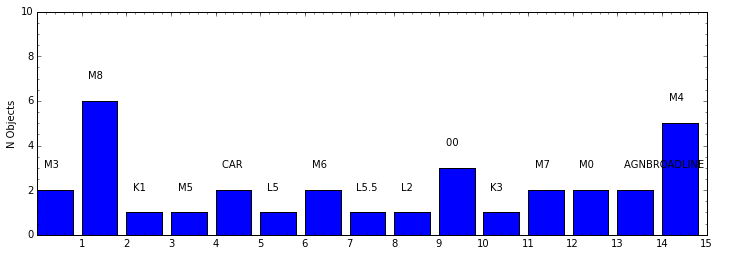

In [98]:
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(range(len(classes)), numbers)
for ii in range(len(classes)):
    ax.text(ii+0.15, numbers[ii]+1, classes[ii])

ax.set_xlim(0,15)
ax.set_ylim(0,10)
ax.set_ylabel("N Objects")
ax.set_xticks(range(1, len(classes)+1))
ax.minorticks_on()
plt.savefig("../figures/contaminating_sspp_objects_classes.pdf")
plt.show()

### SSPP Contaminants in Color-Color Space
We want to see if the contaminating SSPP objects are clustered or randomly distributed.

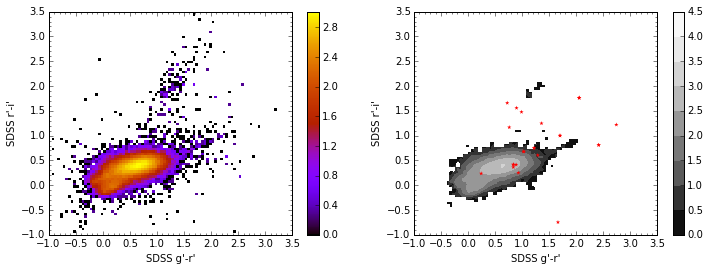

In [108]:
xbins = np.arange(-2,5+.05,.05)
ybins = np.arange(-2,5+.05,.05)

H, xedges, yedges = np.histogram2d(sspp.GR, sspp.RI, bins=(xbins,ybins))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.gnuplot, origin="lower")
plt.colorbar()

plt.xlabel("SDSS g'-r'")
plt.ylabel("SDSS r'-i'")
plt.xlim(-1,3.5)
plt.ylim(-1,3.5)
plt.minorticks_on()

plt.subplot(122)
plt.contourf(np.log10(H.T), levels=np.arange(0,5,0.5),extent=extent, aspect="auto", interpolation="nearest", cmap=plt.cm.Greys_r)
plt.colorbar()
plt.scatter(cut_sspp.GR, cut_sspp.RI,c='red', edgecolor="None",marker="*")

plt.xlabel("SDSS g'-r'")
plt.ylabel("SDSS r'-i'")
plt.xlim(-1,3.5)
plt.ylim(-1,3.5)
plt.minorticks_on()
plt.savefig("../figures/contaminating_sspp_objects.pdf")
plt.show()